In [1]:
# Librerías a usar
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Implementación del filtro de Kalman para un modelo de velocidad constante en Python

Situación cubierta: Cuando uno va manejando un vehículo en un túnel y la señal del GPS se pierde. Ahora el auto tiene que determinar donde está en el túnel. La única información que se tiene es la velocidad en la dirección de conducción. Las componentes de la velocidad ($\dot x$ e $\dot y$) pueden ser calculadas con la velocidad absoluta (revoluciones de las ruedas) y con el rumbo del vehículo (sensor de rotación).

### Vector de estado

Modelo de velocidad constante para "Egomotion"

$$
x_k=[\text{matriz } xy\dot{x}\dot{y}]=\text{matriz Posición X Posición Y Velocidad X Velocidad Y}
$$
Definición formal
\begin{align*}
x_{k+1}&=A\cdot x_k\\
&=\quad
\begin{bmatrix}
1 & 0 & \Delta t & 0 \\
0 & 1 & 0 & \Delta t \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}\cdot  \Big[xy \dot{x}\dot{y}\Big]_k
\end{align*}

Modelo de observación

\begin{align*}
y&=H\cdot x\\
&=\quad
\begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 
\end{bmatrix}\cdot  x
\end{align*}

Esto significa que usted observa la velocidad directamente en la unidad correcta.

### Estado inicial

$$x_0= \quad
\begin{bmatrix}
0 \\
0 \\
0 \\
0 \\
\end{bmatrix}
$$

In [2]:
x = np.matrix([[0.0, 0.0, 0.0, 0.0]]).T
print(x, x.shape)

[[0.]
 [0.]
 [0.]
 [0.]] (4, 1)


### Incertidumbre inicial

$$
P_0=\quad
\begin{bmatrix}
\sigma_x^2 & 0 & 0 & 0 \\
0 & \sigma_y^2 & 0 & 0 \\
0 & 0 & \sigma_{\dot{x}}^2 & 0 \\
0 & 0 & 0 & \sigma_{\dot{y}}^2
\end{bmatrix}
$$

Donde $\sigma$ es la desviación estandar.

In [3]:
P = np.diag([1000.0, 1000.0, 1000.0, 1000.0])
print(P, P.shape)

[[1000.    0.    0.    0.]
 [   0. 1000.    0.    0.]
 [   0.    0. 1000.    0.]
 [   0.    0.    0. 1000.]] (4, 4)


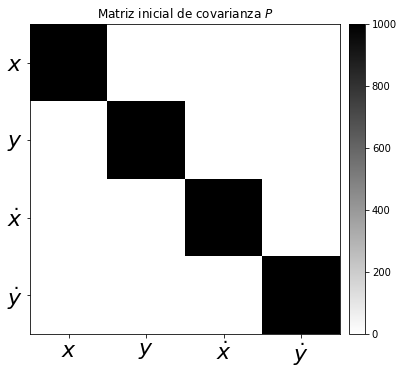

In [4]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Matriz inicial de covarianza $P$')
ylocs, ylabels = plt.yticks()
# Se establecen las ubicaciones de los yticks
plt.yticks(np.arange(7))
# Se establecen las ubicaciones y las etiquetas de los yticks
plt.yticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# Se establecen las ubicaciones de los yticks
plt.xticks(np.arange(7))
# Se establecen las ubicaciones y las etiquetas de los yticks
plt.xticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

plt.xlim([-0.5,3.5])
plt.ylim([3.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax);

### Matriz dinámica $A$

Esta matriz se calcula mediante la dinámica del "Egomotion".
$$
\dot{y}_{k+1}=\dot{y}_k
$$

In [5]:
dt = 0.1 # Paso de tiempo entre cada paso del filtro

A = np.matrix([[1.0, 0.0, dt, 0.0],
              [0.0, 1.0, 0.0, dt],
              [0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
print(A, A.shape)

[[1.  0.  0.1 0. ]
 [0.  1.  0.  0.1]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]] (4, 4)


### Matriz de medición $H$

La velocidad $\dot{x}$ e $\dot{y}$ se mide directamente.
$$
H=\quad
\begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 
\end{bmatrix}
$$

In [6]:
H = np.matrix([[0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
print(H, H.shape)

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]] (2, 4)


### Medición de la covarianza del ruido $R$

Le dice al filtro de Kalman que tan malas son las lecturas del sensor.
$$
R=\quad
\begin{bmatrix}
\sigma_{\dot{x}}^2 & 0 \\
0 & \sigma_{\dot{y}}^2  
\end{bmatrix}
$$

In [7]:
ra = 10.0**2

R = np.matrix([[ra, 0.0],
              [0.0, ra]])
print(R, R.shape)

[[100.   0.]
 [  0. 100.]] (2, 2)


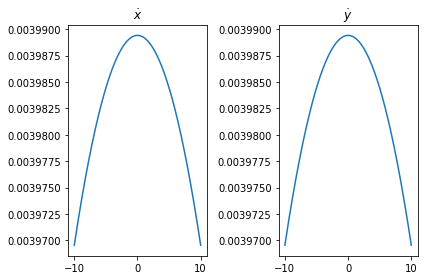

In [8]:
# Graficamos entre -10 y 10 con .001 pasos.
xpdf = np.arange(-10, 10, 0.001)
plt.subplot(121)
plt.plot(xpdf, norm.pdf(xpdf,0,R[0,0]))
plt.title('$\dot x$')

plt.subplot(122)
plt.plot(xpdf, norm.pdf(xpdf,0,R[1,1]))
plt.title('$\dot y$')
plt.tight_layout()

### Procesamiento de la covarianza del ruido $Q$

La posición del vehículo puede ser influenciada por una fuerza (por ejemplo, el viente), lo que lleva a una aceleración perturbada (ruido). Este proceso de ruido puede ser modelado con la matriz de procesamiento de la covarianza del ruido $Q$.
$$
Q=\quad
\begin{bmatrix}
\sigma_{x}^2 & \sigma_{xy}^2 & \sigma_{x\dot{x}}^2 & \sigma_{x\dot{y}}^2 \\
\sigma_{yx}^2 & \sigma_y^2 & \sigma_{y\dot{x}}^2 & \sigma_{y\dot{y}}^2 \\
\sigma_{\dot{x}x}^2 & \sigma_{\dot{x}y}^2 & \sigma_{\dot{x}}^2 & \sigma_{\dot{x}\dot{y}}^2 \\
\sigma_{\dot{y}x}^2 & \sigma_{\dot{y}y}^2 & \sigma_{\dot{y}\dot{x}}^2 & \sigma_{\dot{y}}^2
\end{bmatrix}
$$
La matriz $Q$ se puede calcular como
$$
Q=G\cdot G^T\cdot \sigma_{y}^2
$$
Donde $G=[0.5 \Delta t^2\ 0.5 \Delta t^2\ dt\ dt]^T$ y $\sigma_{y}$ es la aceleración del procesamiento del ruido, la cual puede ser asumida igual a $8.8 [m/s^2]$.

In [9]:
sv = 8.8

G = np.matrix([[0.5*dt**2],
               [0.5*dt**2],
               [dt],
               [dt]])

Q = G*G.T*sv**2

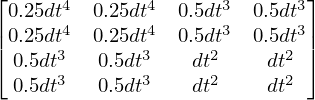

In [10]:
from sympy import Symbol, Matrix
from sympy.interactive import printing

printing.init_printing()
dts = Symbol('dt')
Qs = Matrix([[0.5*dts**2],[0.5*dts**2],[dts],[dts]])
Qs*Qs.T

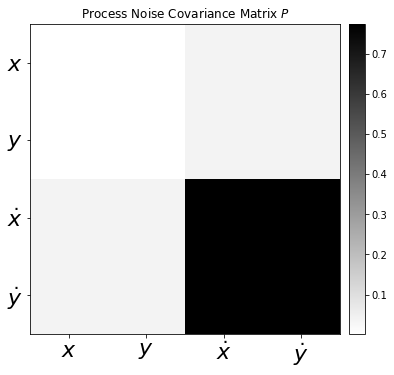

In [11]:
fig = plt.figure(figsize=(6, 6))
im = plt.imshow(Q, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Process Noise Covariance Matrix $P$')
ylocs, ylabels = plt.yticks()
# Se establecen las ubicaciones de los yticks
plt.yticks(np.arange(7))
# Se establecen las ubicaciones y las etiquetas de los yticks
plt.yticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# Se establecen las ubicaciones de los yticks
plt.xticks(np.arange(7))
# Se establecen las ubicaciones y las etiquetas de los yticks
plt.xticks(np.arange(6),('$x$', '$y$', '$\dot x$', '$\dot y$'), fontsize=22)

plt.xlim([-0.5,3.5])
plt.ylim([3.5, -0.5])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax);

### Matriz identidad $I$

In [12]:
I = np.eye(4)
print(I, I.shape)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] (4, 4)


### Mediciones

A modo de ejemplo, usaremos valores de medicines generados de forma aleatoria.

In [13]:
m = 200 # Mediciones
vx= 20 # en X
vy= 10 # en Y

mx = np.array(vx+np.random.randn(m))
my = np.array(vy+np.random.randn(m))

measurements = np.vstack((mx,my))

print(measurements.shape)

print('Desviación estandar de las mediciones de aceleraciones =%.2f' % np.std(mx))
print('Se asume %.2f en R.' % R[0,0])

(2, 200)
Desviación estandar de las mediciones de aceleraciones =0.98
Se asume 100.00 en R.


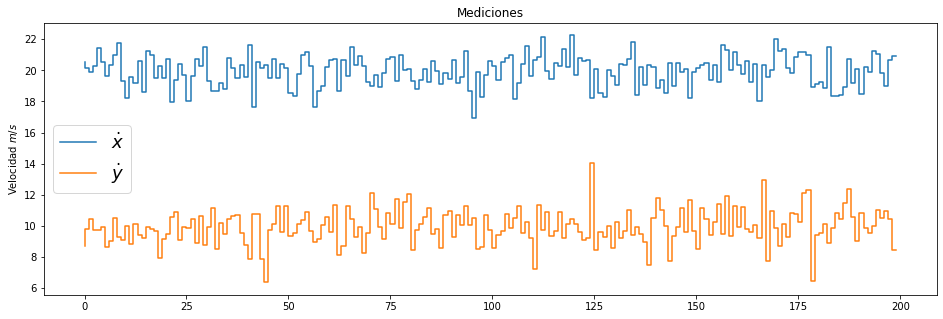

In [14]:
fig = plt.figure(figsize=(16,5))

plt.step(range(m),mx, label='$\dot x$')
plt.step(range(m),my, label='$\dot y$')
plt.ylabel(r'Velocidad $m/s$')
plt.title('Mediciones')
plt.legend(loc='best',prop={'size':18})

In [15]:
# Preasignación para graficar
xt = []
yt = []
dxt= []
dyt= []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Rdx= []
Rdy= []
Kx = []
Ky = []
Kdx= []
Kdy= []

def savestates(x, Z, P, R, K):
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    dxt.append(float(x[2]))
    dyt.append(float(x[3]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Rdx.append(float(R[0,0]))
    Rdy.append(float(R[1,1]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))

## Filtro de Kalman

In [16]:
for n in range(len(measurements[0])):
    # Actualización del tiempo (Predicción)
    # ========================
    # Proyección del estado siguiente
    x = A*x
    
    # Proyección del error de la covarianza siguiente
    P = A*P*A.T + Q
    
    # Actualización de la medición (Corrección)
    # ===============================
    # Se calcula el filtro de Kalman
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)
    
    # Se actualiza la estimación con z
    Z = measurements[:,n].reshape(2,1)
    y = Z - (H*x)  
    x = x + (K*y)
    
    # Se actualiza el error de la covarianza
    P = (I - (K*H))*P
    
    # Guardar los estados (para graficar)
    savestates(x, Z, P, R, K)

## Comportamiento del filtro

### Ganancias de Kalman $k$

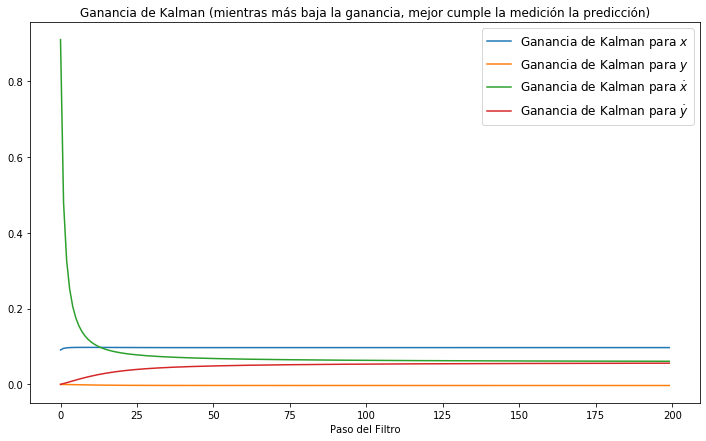

In [17]:
def plot_K():
    fig = plt.figure(figsize=(12,7))
    plt.plot(range(len(measurements[0])),Kx, label='Ganancia de Kalman para $x$')
    plt.plot(range(len(measurements[0])),Ky, label='Ganancia de Kalman para $y$')
    plt.plot(range(len(measurements[0])),Kdx, label='Ganancia de Kalman para $\dot x$')
    plt.plot(range(len(measurements[0])),Kdy, label='Ganancia de Kalman para $\dot y$')

    plt.xlabel('Paso del Filtro')
    plt.ylabel('')
    plt.title('Ganancia de Kalman (mientras más baja la ganancia, mejor cumple la medición la predicción)')
    plt.legend(loc='best',prop={'size':12})

plot_K()

### Matriz de incertidumbre $P$

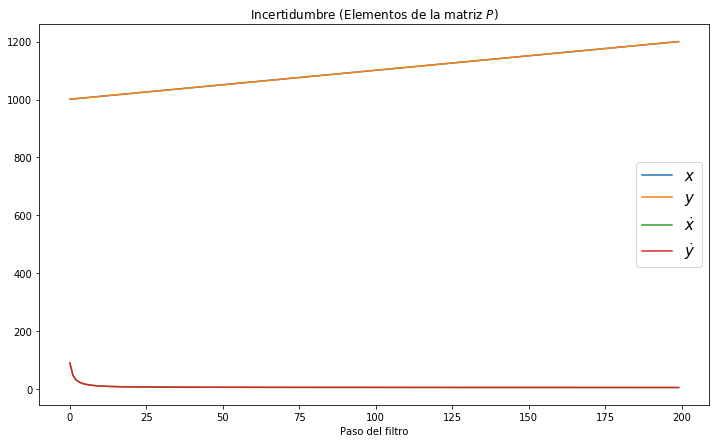

In [18]:
def plot_P():
    fig = plt.figure(figsize=(12,7))
    plt.plot(range(len(measurements[0])),Px, label='$x$')
    plt.plot(range(len(measurements[0])),Py, label='$y$')
    plt.plot(range(len(measurements[0])),Pdx, label='$\dot x$')
    plt.plot(range(len(measurements[0])),Pdy, label='$\dot y$')

    plt.xlabel('Paso del filtro')
    plt.ylabel('')
    plt.title('Incertidumbre (Elementos de la matriz $P$)')
    plt.legend(loc='best',prop={'size':15})
    
plot_P()

### Estimación del estado $x$

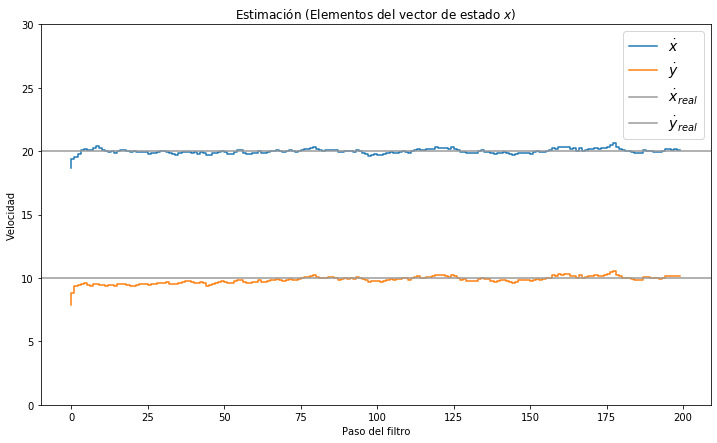

In [19]:
def plot_x():
    fig = plt.figure(figsize=(12,7))
    plt.step(range(len(measurements[0])),dxt, label='$\dot x$')
    plt.step(range(len(measurements[0])),dyt, label='$\dot y$')

    plt.axhline(vx, color='#999999', label='$\dot x_{real}$')
    plt.axhline(vy, color='#999999', label='$\dot y_{real}$')

    plt.xlabel('Paso del filtro')
    plt.title('Estimación (Elementos del vector de estado $x$)')
    plt.legend(loc='best',prop={'size':14})
    plt.ylim([0, 30])
    plt.ylabel('Velocidad')
    
plot_x()

### Posición $x/y$

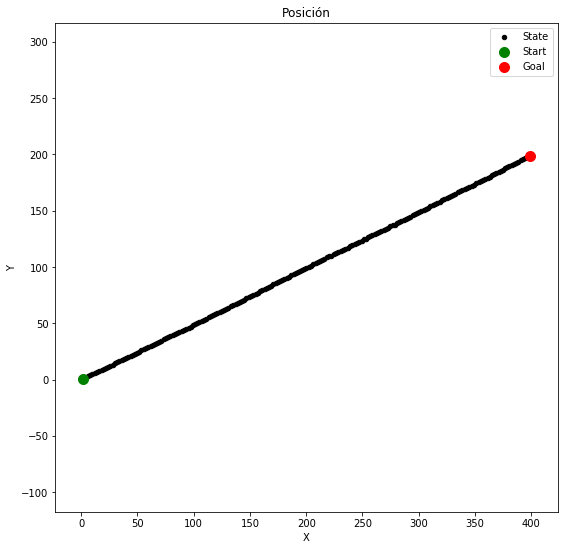

In [20]:
def plot_xy():
    fig = plt.figure(figsize=(9,9))
    plt.scatter(xt,yt, s=20, label='State' ,c='k')
    plt.scatter(xt[0],yt[0], s=100, label='Start', c='g')
    plt.scatter(xt[-1],yt[-1], s=100, label='Goal', c='r')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Posición')
    plt.legend(loc='best')
    plt.axis('equal')
    
plot_xy()

## Conclusión

Los resultados se ven bastante bien, ya que los valores estimados están muy cerca de los valores reales de cada componente de la velocidad.